# KE5108 Time Series Forecasting

## Load Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Data

In [2]:
train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


In [3]:
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444


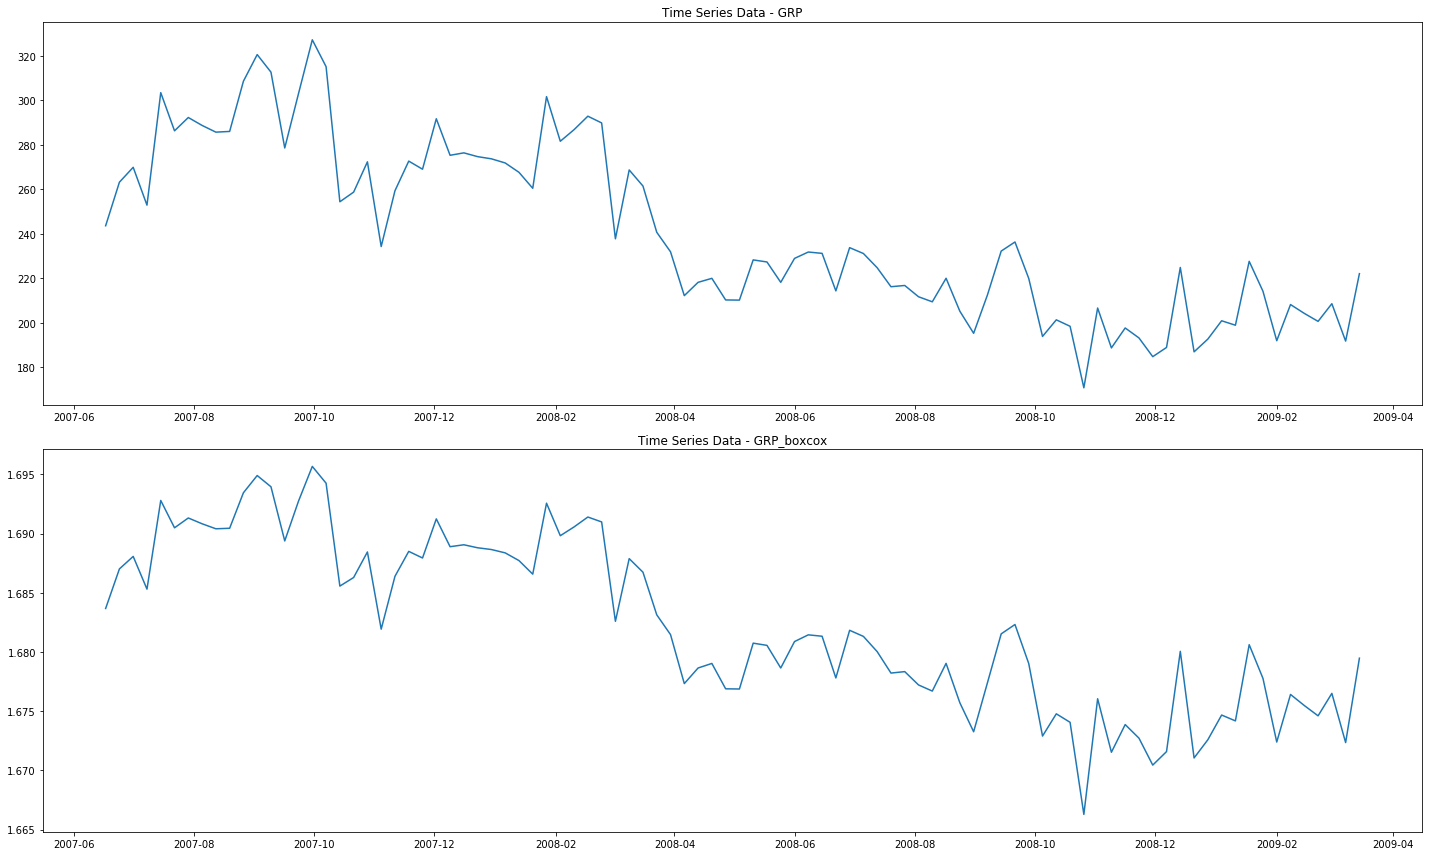

In [4]:
a_df = train_ts_df.append(test_ts_df)
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.plot(a_df['GRP'])
plt.title("Time Series Data - GRP")
plt.subplot(212)
plt.plot(a_df['GRP_boxcox'])
plt.title("Time Series Data - GRP_boxcox")
plt.tight_layout()
plt.show()

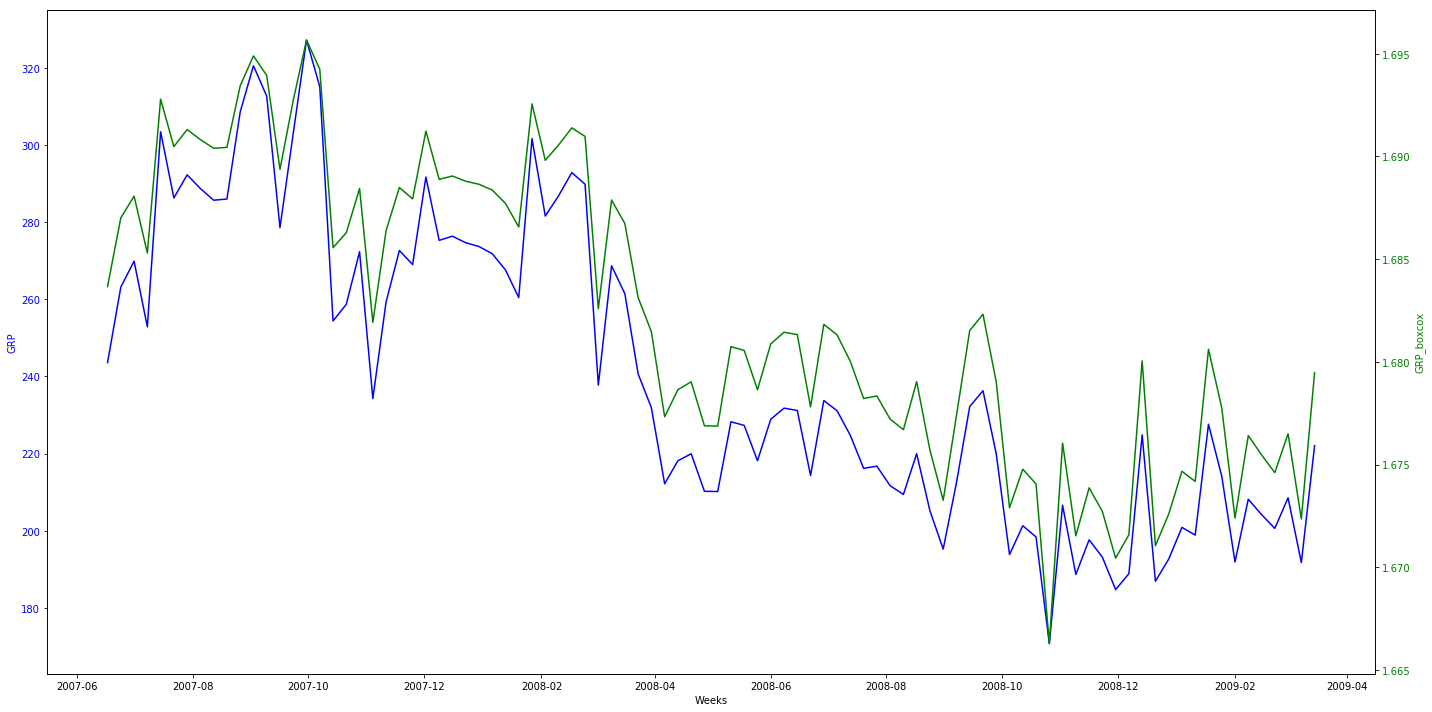

In [5]:
a_df = train_ts_df.append(test_ts_df)
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

ax1.set_xlabel('Weeks')
ax1.set_ylabel('GRP', color='blue')
ax1.plot(a_df['GRP'], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'green'
ax2.set_ylabel('GRP_boxcox', color='green')  # we already handled the x-label with ax1
ax2.plot(a_df['GRP_boxcox'], color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Classical Decomposition Method

In [6]:
# Plots the trend, seasonal and residual of the decomposition method.
def plot_decomp(ts_df, freq, model='multiplicative', two_sided=False):
    decomp = sm.tsa.seasonal_decompose(ts_df, model=model, two_sided=two_sided, freq=freq)
    fig = decomp.plot()
    fig.set_size_inches(15, 7)
    fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(freq) + ' Periods')
    plt.show()
    return decomp

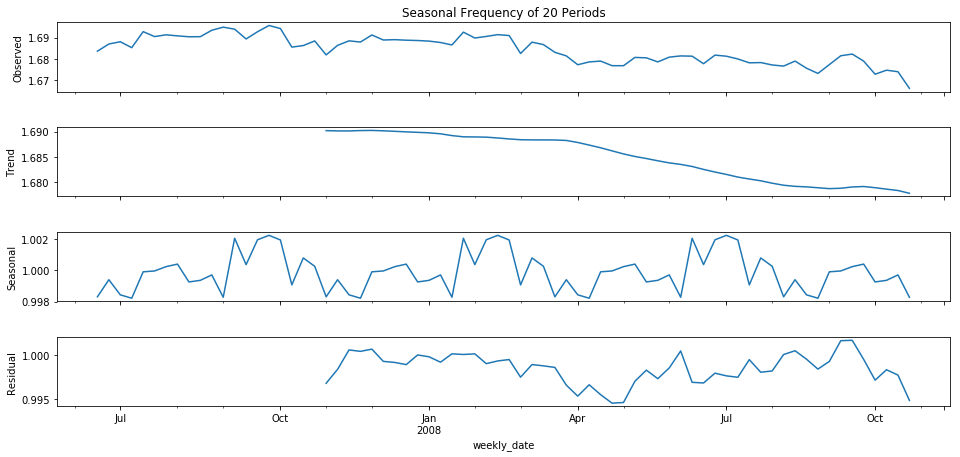

In [7]:
# Number of time series periods in a season = 20 (weeks) or 5 months
decomp20 = plot_decomp(train_ts_df['GRP_boxcox'], freq=20)

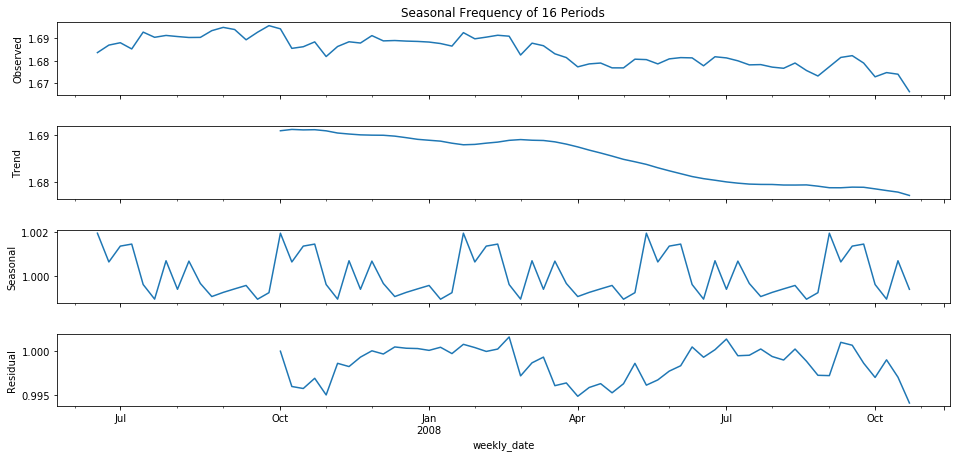

In [8]:
# Number of time series periods in a season = 16 (weeks) or 4 months
decomp16 = plot_decomp(train_ts_df['GRP_boxcox'], freq=16)

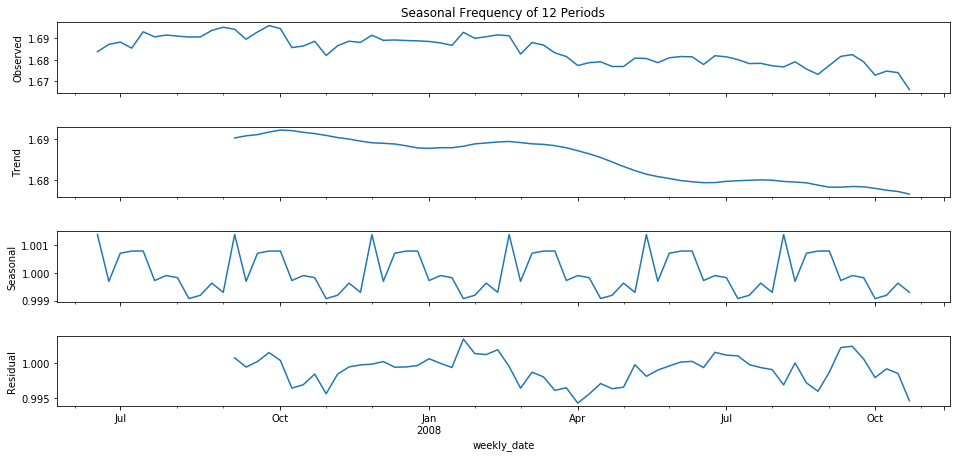

In [9]:
# Number of time series periods in a season = 12 (weeks) or 3 months
decomp12 = plot_decomp(train_ts_df['GRP_boxcox'], freq=12)

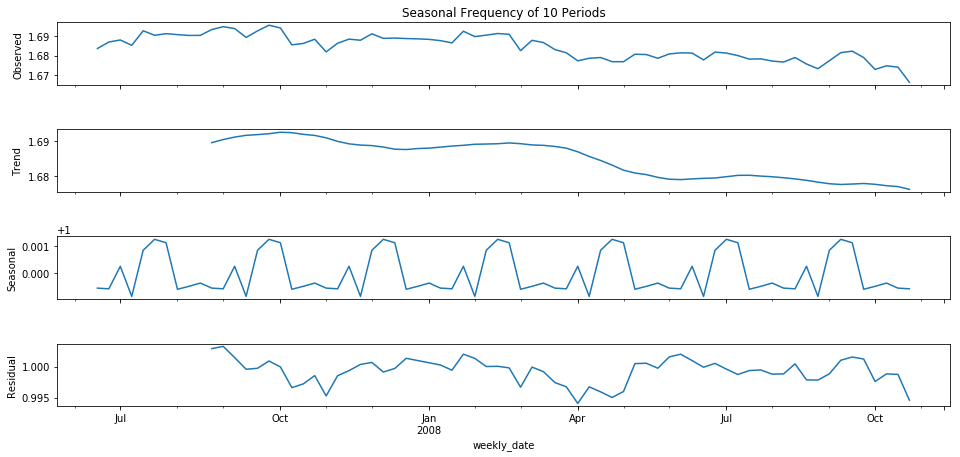

In [10]:
# Number of time series periods in a season = 10 (weeks) or 2.5 months
decomp10 = plot_decomp(train_ts_df['GRP_boxcox'], freq=10)

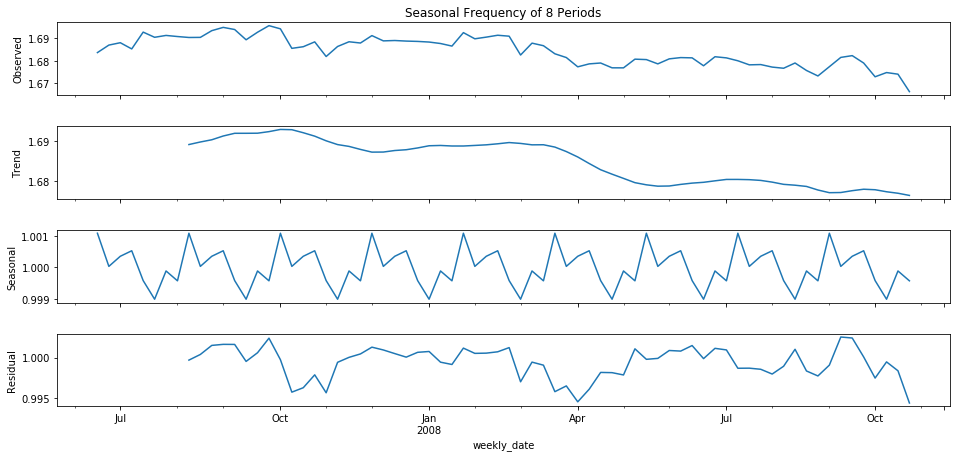

In [11]:
# Number of time series periods in a season = 8 (weeks) or 2 months
decomp8 = plot_decomp(train_ts_df['GRP_boxcox'], freq=8)

### Analysis of Residuals

In [12]:
def plot_residuals(resid, isMult=True, deg=3, title='Residuals by Week'):

    a_resid = resid.copy()
    a_resid.reset_index(drop=True, inplace=True)
    a_resid.dropna(inplace=True)
    idx = a_resid.index.values.reshape(-1, 1)
    
    poly_reg = Pipeline(
        [
            ('poly', PolynomialFeatures(degree=deg)),
            ('linear', LinearRegression(fit_intercept=True))])
    poly_reg.fit(idx, a_resid)
    poly_reg_pred = poly_reg.predict(idx)
    plt.title(title)
    plt.scatter(idx, a_resid, color='black', marker='o', label='residuals', facecolors='none')
    plt.plot(idx, a_resid, color='black', linewidth=1, label='residuals curve', alpha=.5)
    plt.plot(idx, poly_reg_pred, color='blue', linewidth=3, label='regression line')
    if isMult:
        plt.axhline(1)
    else:
        plt.axhline(1)        
    plt.legend()
    return None

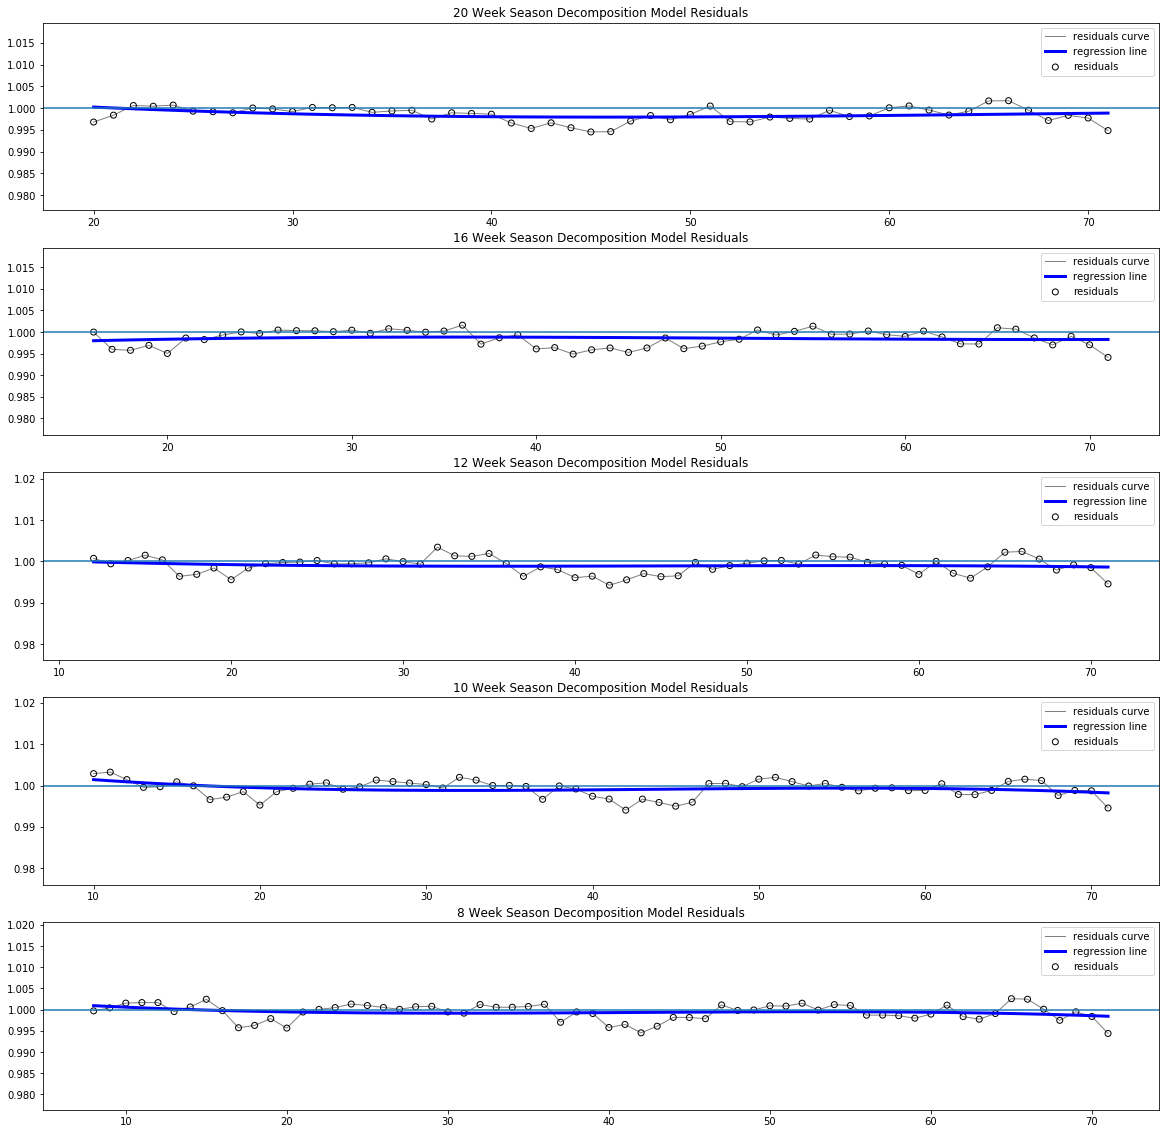

In [13]:
decomp_list = [[decomp20, 20], [decomp16, 16], [decomp12, 12], [decomp10, 10], [decomp8, 8]]
fig, ax = plt.subplots(nrows=len(decomp_list), ncols=1, figsize=(20, 20))
for idx, row in enumerate(ax):
    plt.sca(row)
    plot_residuals(decomp_list[idx][0].resid, isMult=True, deg=3, title=str(decomp_list[idx][1])+' Week Season Decomposition Model Residuals')
plt.show()

### Training / Test Results

20 Week Season Model

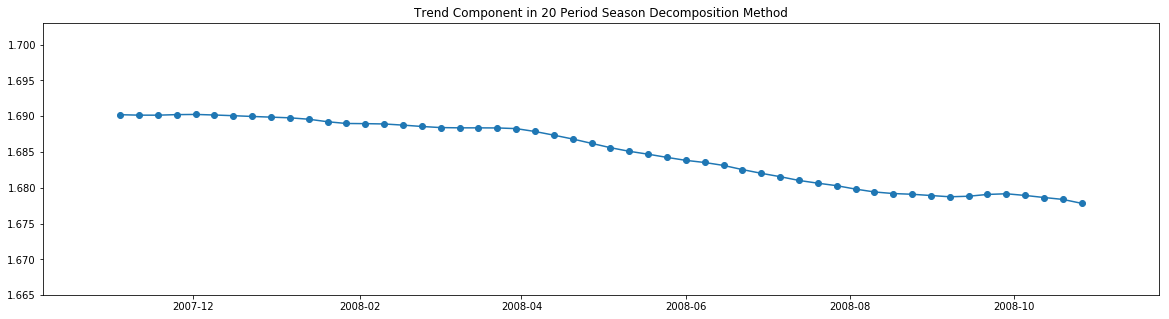

In [14]:
plt.figure(figsize=(20, 5))
plt.scatter(decomp20.trend.index, decomp20.trend.values)
plt.plot(decomp20.trend)
plt.title('Trend Component in 20 Period Season Decomposition Method')
plt.show()

In [15]:
a_trend = decomp20.trend.copy()
a_trend.reset_index(drop=True, inplace=True)
a_trend.dropna(inplace=True)
idx = a_trend.index.values.reshape(-1, 1)
trend_reg = LinearRegression()
# trend_reg = Pipeline(
#     [
#         ('poly', PolynomialFeatures(degree=2)),
#         ('linear', LinearRegression(fit_intercept=True))])
trend_reg.fit(idx, a_trend.values)
train_ts_df['trend'] = trend_reg.predict(train_ts_df['week'].values.reshape(-1, 1))

In [16]:
trend_reg.coef_

array([-0.0002873])

In [17]:
trend_reg.intercept_

1.6980338928671335

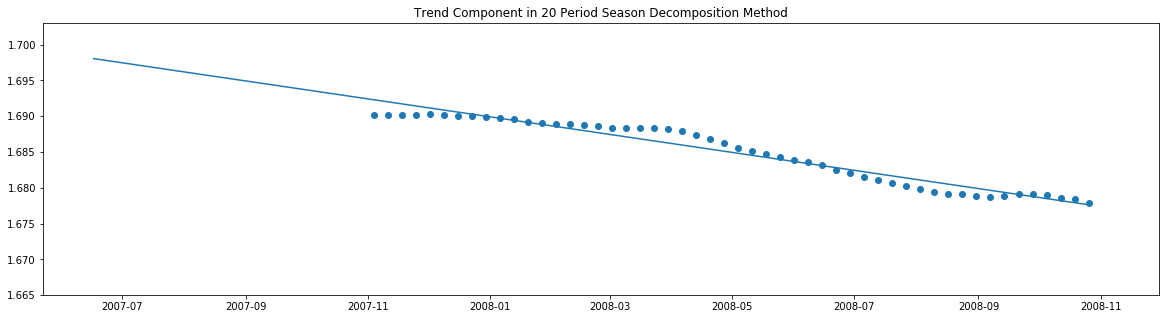

In [18]:
plt.figure(figsize=(20, 5))
plt.scatter(decomp20.trend.index, decomp20.trend.values)
plt.plot(train_ts_df['trend'])
#plt.scatter(decomp20.trend.index.values.reshape(-1, 1), trend_reg.predict(decomp20.trend.index.values.reshape(-1, 1)))
plt.title('Trend Component in 20 Period Season Decomposition Method')
plt.show()

In [19]:
BOXCOX_LAMBDA = -0.5677106

train_ts_df['seasonal'] = decomp20.seasonal
train_ts_df['decomp20'] = inv_boxcox(train_ts_df['trend'] * train_ts_df['seasonal'], BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal,decomp20
weekly_date,,,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,1.698034,0.998304,322.762930
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,1.697747,0.999395,336.622282
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,1.697459,0.998430,319.699332
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,1.697172,0.998214,314.251813
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,1.696885,0.999899,336.575118


In [20]:
test_ts_df['trend'] = trend_reg.predict(test_ts_df['week'].values.reshape(-1, 1))

In [21]:
a_seasonal = decomp20.seasonal[:20]
test_ts_df['seasonal'] = [a_seasonal[i] for i in test_ts_df['week'] % 20]
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal
weekly_date,,,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045,1.677348,1.002041
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528,1.677061,1.000358
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866,1.676774,1.001943
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718,1.676486,1.002225
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444,1.676199,1.001931


In [22]:
test_ts_df['decomp20'] = inv_boxcox(test_ts_df['trend'] * test_ts_df['seasonal'], BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal,decomp20
weekly_date,,,,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045,1.677348,1.002041,228.398231
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528,1.677061,1.000358,213.679580
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866,1.676774,1.001943,224.757572
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718,1.676486,1.002225,225.661334
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444,1.676199,1.001931,221.891119


In [23]:
train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['decomp20'].values)
train_rmse = np.sqrt(train_mse)
train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['decomp20'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['decomp20'].values)
test_rmse = np.sqrt(test_mse)
test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['decomp20'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

print('train mse = %f\ntrain rmse = %f\ntrain mape = %f\ntest mse = %f\ntest rmse = %f\ntest mape = %f\n'
      % (train_mse, train_rmse, train_mape, test_mse, test_rmse, test_mape))

train mse = 799.975955
train rmse = 28.283846
train mape = 8.863256
test mse = 474.504102
test rmse = 21.783115
test mape = 8.823346



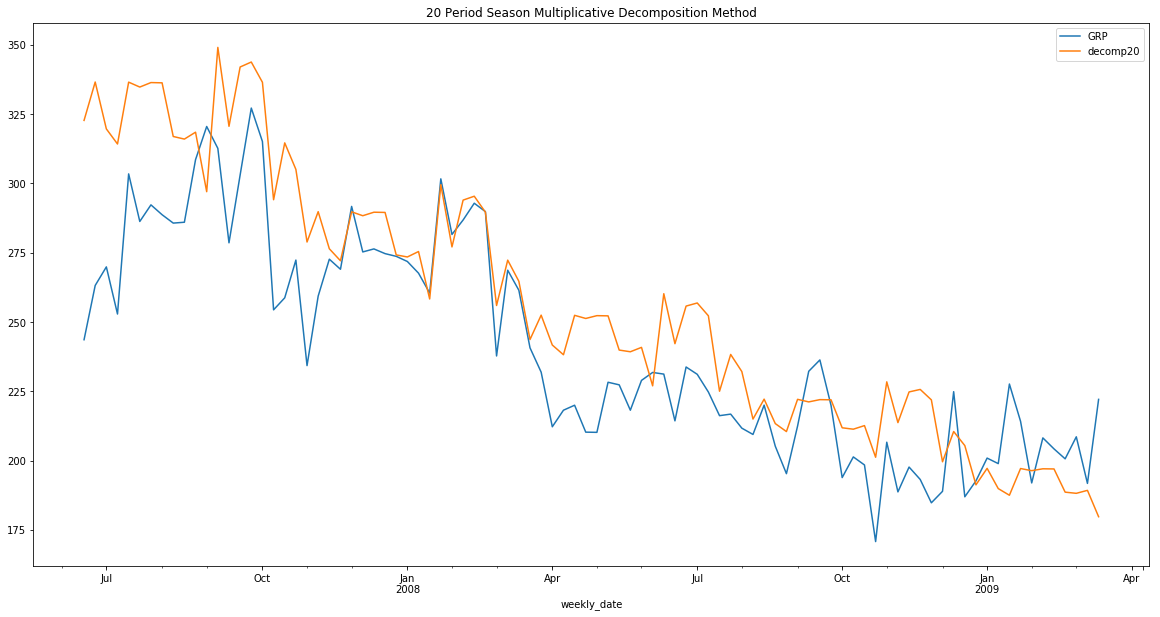

In [24]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'decomp20']].plot(figsize=(20, 10), title="20 Period Season Multiplicative Decomposition Method")

### Analysis of Residuals

In [25]:
my_df = train_ts_df.dropna()
residuals = my_df['GRP'].values - my_df['decomp20']
residuals[:10]

weekly_date
2007-06-17   -79.162930
2007-06-24   -73.432282
2007-07-01   -49.809332
2007-07-08   -61.371813
2007-07-15   -33.115118
2007-07-22   -48.514468
2007-07-29   -44.142341
2007-08-05   -47.608328
2007-08-12   -31.260259
2007-08-19   -30.015551
Name: decomp20, dtype: float64

In [26]:
decomp20_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
decomp20_res.fit(my_df['week'].values.reshape(-1, 1), residuals)
decomp20_res_pred = decomp20_res.predict(my_df['week'].values.reshape(-1, 1))

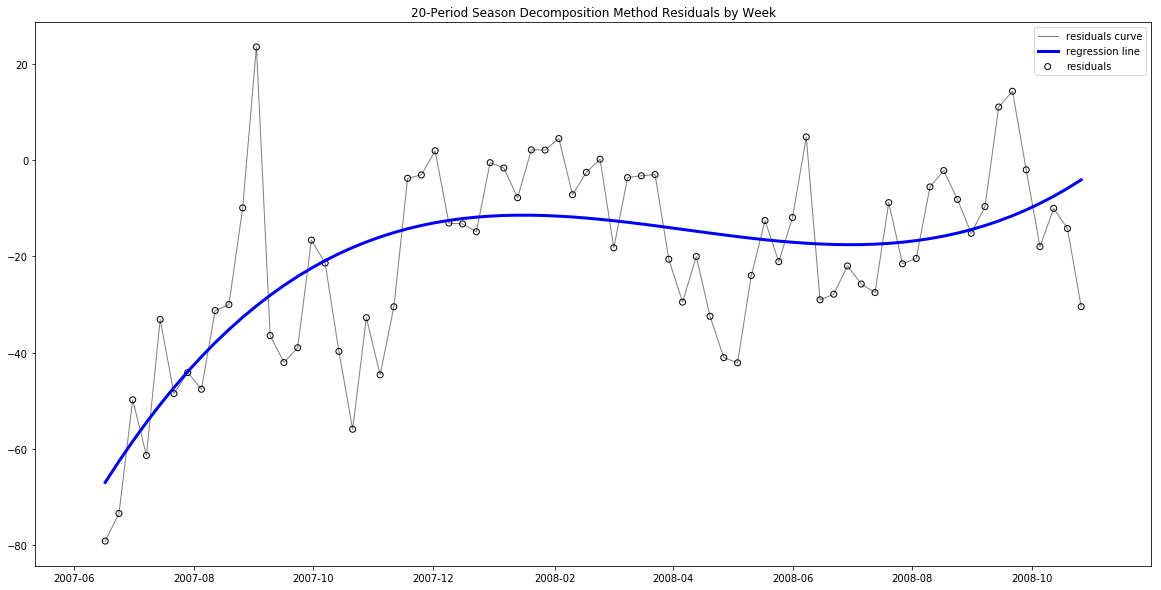

In [27]:
plt.figure(figsize=(20, 10))
plt.title('20-Period Season Decomposition Method Residuals by Week')
plt.scatter(my_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(my_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(my_df.index.values, decomp20_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

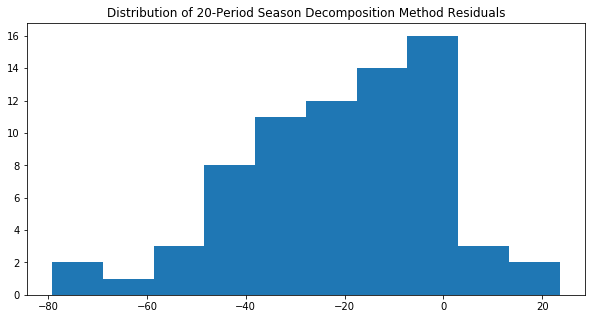

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of 20-Period Season Decomposition Method Residuals')
plt.hist(residuals)
plt.show()

In [29]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,31.717342,1.783228e-08
1,2,45.290847,1.462910e-10
2,3,54.693671,7.981090e-12
3,4,61.036049,1.756909e-12
4,5,65.623097,8.322007e-13
5,6,67.844086,1.130757e-12
6,7,69.240095,2.103835e-12
7,8,69.392231,6.492627e-12
8,9,69.392847,2.002662e-11
9,10,69.810203,4.824075e-11


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


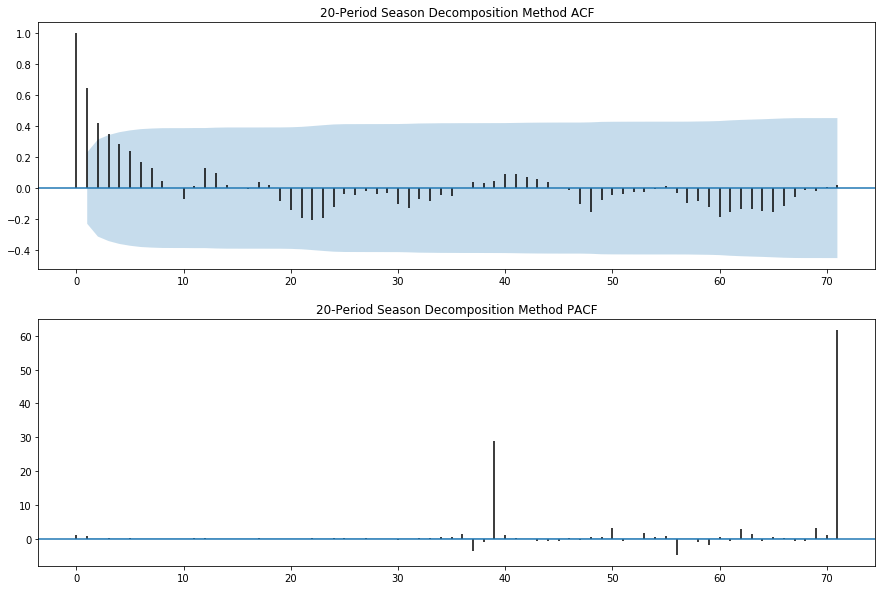

In [30]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='20-Period Season Decomposition Method ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='20-Period Season Decomposition Method PACF', marker=None)
plt.show()

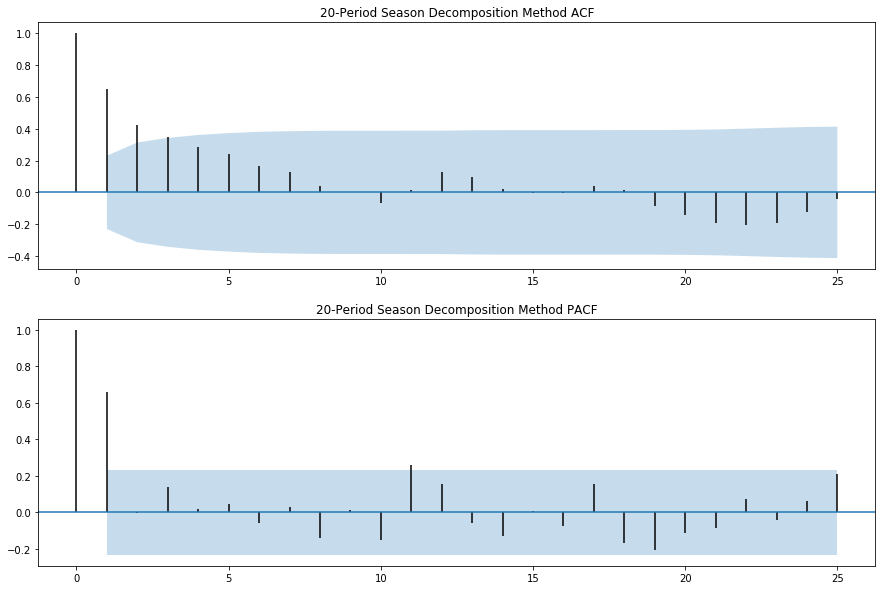

In [31]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=25, title='20-Period Season Decomposition Method ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=25, title='20-Period Season Decomposition Method PACF', marker=None)
plt.show()

The distribution of the residuals are not gaussian and there is autocorrelation in the residuals. The model fails to capture most of the variance in the data.

## Conclusion

In [32]:
results_df = pd.DataFrame([[train_mse, train_rmse, train_mape, test_mse, test_rmse, test_mape]], index=['20 Period Season Decomposition Method'],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test_mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test_mape
20 Period Season Decomposition Method,799.975955,28.283846,8.863256,474.504102,21.783115,8.823346
